# Recommender system with content based similarity

## Import and minor data prep

In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('japan_destination_cleaned_new.csv')

In [3]:
df.head(1)

,Region,Prefecture,City,Link,Description,Rating,Visits,Recommendation
0,Hokkaido,Cities and Resort Towns,Niseko,https://www.japan-guide.com/e/e6720.html,Leading snow resort with lots of powder snow.,4.1,373,Recommended


In [4]:
# drop recommendation column since we are making it again using normalisation
df.drop(columns=['Recommendation'], inplace=True)

In [5]:
df.sample(3)

,Region,Prefecture,City,Link,Description,Rating,Visits
61,Kanto,Saitama,Chichibu,https://www.japan-guide.com/e/e6550.html,Rural city known for its festival and shrines.,3.6,87
153,Chugoku,Yamaguchi,Shimonoseki,https://www.japan-guide.com/e/e6140.html,City at the westernmost tip of Honshu.,3.2,32
88,Chubu,Gifu,Gujo-Hachiman,https://www.japan-guide.com/e/e5930.html,Small town in rural Japan with castle.,3.8,267


In [6]:
df.dtypes

Region          object
Prefecture      object
City            object
Link            object
Description     object
Rating         float64
Visits          object
dtype: object

In [7]:
# replace visits , 
df['Visits'] = df['Visits'].astype(str).str.replace(',', '', regex=False)
# convert to int
df['Visits'] = pd.to_numeric(df['Visits'])

In [8]:
df['Visits'].max()

12216

In [9]:
df.sample(3)

,Region,Prefecture,City,Link,Description,Rating,Visits
143,Chugoku,Hiroshima,Miyajima,https://www.japan-guide.com/e/e3401.html,Island known for its shrine and large torii gate.,4.7,3125
199,Kyushu,Miyazaki,Udo Shrine,https://www.japan-guide.com/e/e8032.html,Shrine constructed in a cliff side cave.,3.6,102
34,Tohoku,Iwate,Tono,https://www.japan-guide.com/e/e5060.html,Rural town known for its folktales and legends.,4.2,44


## Data analysis

### Summary for ratings and visits

In [10]:
df['Rating'].describe()

count    212.000000
mean       3.568396
std        0.870905
min        0.000000
25%        3.400000
50%        3.700000
75%        4.000000
max        4.800000
Name: Rating, dtype: float64

In [11]:
df['Visits'].describe()

count      212.000000
mean       748.349057
std       1450.102745
min          4.000000
25%        108.500000
50%        294.000000
75%        646.000000
max      12216.000000
Name: Visits, dtype: float64

### Data visualisation

Text(0, 0.5, 'Frequency')

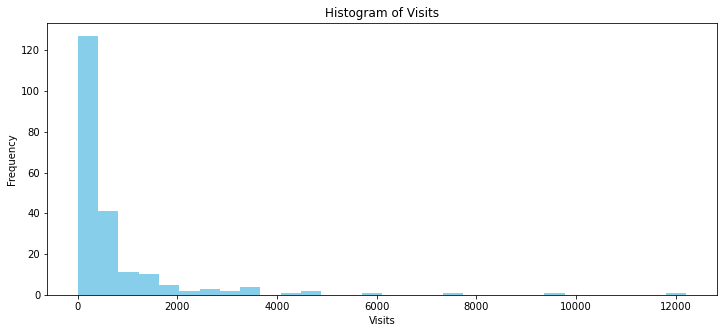

In [12]:
plt.figure(figsize=(12,5))

# Histogram for Visit
plt.hist(df['Visits'], bins=30, color='skyblue')
plt.title('Histogram of Visits')
plt.xlabel('Visits')
plt.ylabel('Frequency')

we can see that in destinations visits, there are some places which are very popular with many visits and most places have very little visits

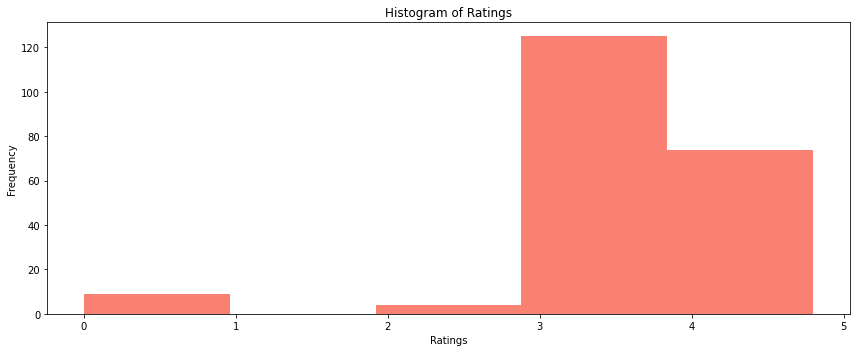

In [13]:
plt.figure(figsize=(12,5))
# Histogram for Ratings

plt.hist(df['Rating'], bins=5, color='salmon')
plt.title('Histogram of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this we can see that there are outliers in ratings with 0 as there might be less visits to a place thus no ratings

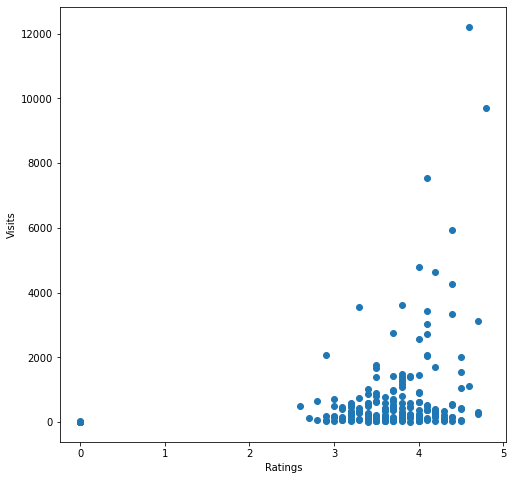

In [14]:
#scatter plot between ratings and visits
plt.figure(figsize=(8,8))
plt.scatter(df['Rating'], df['Visits'])
plt.xlabel('Ratings')
plt.ylabel('Visits')
plt.show()

here we can see an obvious outlier where there is minimal visits with a low/zero rating, and some places with a high visit and rating. However most places are condensed within the 3-4 rating and <2000 visits zone

## Create different recommendation types

In [23]:
# Normalize the data for scoring
df['Rating_Normalized'] = df['Rating'] / df['Rating'].max()
df['Visits_Normalized'] = df['Visits'] / df['Visits'].max()

# Calculate different recommendation scores
def calculate_scores(df):
    """Calculate recommendation scores for different types"""
    
    # 1. balacned: Equal weight to rating and popularity
    df['Balanced_Score'] = (df['Rating_Normalized'] + df['Visits_Normalized']) / 2
    
    # 2. POPULAR: Skew score towards visits more, but consider rating
    df['Popular_Score'] = (df['Visits_Normalized'] * 0.65 + 0.35) * (df['Rating_Normalized'])
    
    # 3. HIDDEN GEM: Skew score towards ratings more, but consider visits
    df['Hidden_Gem_Score'] = df['Rating_Normalized'] * 0.65 + (1 - df['Visits_Normalized']) * 0.35
    
    return df

df = calculate_scores(df)

#Display scores
print("Normalized Scores:")
score_cols = ['City', 'Rating', 'Visits', 'Rating_Normalized', 'Visits_Normalized', 
              'Balanced_Score', 'Popular_Score', 'Hidden_Gem_Score']
print(df[score_cols].round(3))
print("\n" + "="*50 + "\n")

Normalized Scores:
                City  Rating  Visits  Rating_Normalized  Visits_Normalized  \
0             Niseko     4.1     373              0.854              0.031   
1            Sapporo     4.0    2572              0.833              0.211   
2             Furano     4.0     886              0.833              0.073   
3        Noboribetsu     4.0     619              0.833              0.051   
4           Hakodate     3.9    1408              0.812              0.115   
..               ...     ...     ...                ...                ...   
207  Yaeyama Islands     4.7     248              0.979              0.020   
208   Kerama Islands     4.5      39              0.938              0.003   
209   Okinawa Island     4.5    2016              0.938              0.165   
210    Miyako Island     4.4     169              0.917              0.014   
211      Kume Island     4.0      56              0.833              0.005   

     Balanced_Score  Popular_Score  Hidden_G

In [24]:
# Function to get recommendations
def get_recommendations(df, rec_type='balanced', top_n=None):
    """
    Get recommendations based on type
    
    Parameters:
    - rec_type: 'balanced', 'popular', or 'hidden_gem'
    - top_n: number of recommendations (None for all)
    """
    
    score_column = f'{rec_type.title().replace("_", "_")}_Score'
    
    # Sort by score (descending)
    sorted_df = df.sort_values(score_column, ascending=False)
    
    if top_n:
        sorted_df = sorted_df.head(top_n)
    
    return sorted_df

In [25]:
print("RECOMMENDATION RESULTS:")
print("="*25)

score_column_map = {
    'balanced': 'Balanced_Score',
    'popular': 'Popular_Score',
    'hidden_gem': 'Hidden_Gem_Score'
}

for rec_type in ['balanced', 'popular', 'hidden_gem']:
    print(f"\n{rec_type.upper().replace('_', ' ')} RECOMMENDATIONS:")
    print("-" * 30)
    
    recommendations = get_recommendations(df, rec_type)
    score_col = score_column_map[rec_type]
    
    for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
        print(f"{i}. {row['City']} ({row['Prefecture']}, {row['Region']})")
        print(f"   Score: {row[score_col]:.3f}")
        print(f"   Rating: {row['Rating']}/5.0 | Visits: {row['Visits']:,}")
        print(f"   {row['Description']}")
        print()


RECOMMENDATION RESULTS:

BALANCED RECOMMENDATIONS:
------------------------------
1. Tokyo (Tokyo Metropolis, Kanto)
   Score: 0.979
   Rating: 4.6/5.0 | Visits: 12,216
   Japan's capital and largest city.

2. Kyoto (Kyoto, Kansai)
   Score: 0.897
   Rating: 4.8/5.0 | Visits: 9,699
   For over 1000 years the capital of Japan.

3. Osaka (Osaka, Kansai)
   Score: 0.735
   Rating: 4.1/5.0 | Visits: 7,535
   Largest city of the Kinki Region.

4. Nara (Nara, Kansai)
   Score: 0.701
   Rating: 4.4/5.0 | Visits: 5,928
   Japan's first permanent capital.

5. Kamakura (Kanagawa, Kanto)
   Score: 0.633
   Rating: 4.4/5.0 | Visits: 4,277
   Small city full of historic treasures.

6. Hiroshima (Hiroshima, Chugoku)
   Score: 0.628
   Rating: 4.2/5.0 | Visits: 4,649
   Regional capital with a tragic history.

7. Miyajima (Hiroshima, Chugoku)
   Score: 0.617
   Rating: 4.7/5.0 | Visits: 3,125
   Island known for its shrine and large torii gate.

8. Yokohama (Kanagawa, Kanto)
   Score: 0.612
   Rating

28. Okinawa Island (Okinawa, Okinawa)
   Score: 0.902
   Rating: 4.5/5.0 | Visits: 2,016
   Okinawa Prefecture's main island.

29. Ouchijuku (Fukushima, Tohoku)
   Score: 0.901
   Rating: 4.1/5.0 | Visits: 132
   Former post town along a trade route.

30. Miyajima (Hiroshima, Chugoku)
   Score: 0.897
   Rating: 4.7/5.0 | Visits: 3,125
   Island known for its shrine and large torii gate.

31. Daisetsuzan (National Parks, Hokkaido)
   Score: 0.895
   Rating: 4.1/5.0 | Visits: 363
   Hokkaido's largest and wildest national park.

32. Yoshino (Nara, Kansai)
   Score: 0.895
   Rating: 4.1/5.0 | Visits: 370
   Japan's most famous cherry blossom spot.

33. Niseko (Cities and Resort Towns, Hokkaido)
   Score: 0.895
   Rating: 4.1/5.0 | Visits: 373
   Leading snow resort with lots of powder snow.

34. Kinosaki (Hyogo, Kansai)
   Score: 0.891
   Rating: 4.1/5.0 | Visits: 502
   Pleasant, old-fashioned hot spring resort.

35. Takato Castle Park (Nagano, Chubu)
   Score: 0.891
   Rating: 4.0/5.0 |

In [26]:
df.describe()

,Rating,Visits,Rating_Normalized,Visits_Normalized,Balanced_Score,Popular_Score,Hidden_Gem_Score
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,3.568396,748.349057,0.743416,0.061260,0.402338,0.293408,0.811779
std,0.870905,1450.102745,0.181438,0.118705,0.120596,0.107309,0.114434
min,0.000000,4.000000,0.000000,0.000327,0.000164,0.000000,0.349255
25%,3.400000,108.500000,0.708333,0.008882,0.362578,0.255938,0.781681
50%,3.700000,294.000000,0.770833,0.024067,0.402351,0.286474,0.830771
75%,4.000000,646.000000,0.833333,0.052881,0.447697,0.321025,0.865387
max,4.800000,12216.000000,1.000000,1.000000,0.979167,0.958333,0.979353


In [28]:
# view balanced to see if results makes sense to a normal user 
df.sort_values(by='Balanced_Score', ascending=False).head(6)

,Region,Prefecture,City,Link,Description,Rating,Visits,Rating_Normalized,Visits_Normalized,Balanced_Score,Popular_Score,Hidden_Gem_Score
52,Kanto,Tokyo Metropolis,Tokyo,https://www.japan-guide.com/e/e2164.html,Japan's capital and largest city.,4.6,12216,0.958333,1.000000,0.979167,0.958333,0.622917
120,Kansai,Kyoto,Kyoto,https://www.japan-guide.com/e/e2158.html,For over 1000 years the capital of Japan.,4.8,9699,1.000000,0.793959,0.896979,0.866073,0.722114
124,Kansai,Osaka,Osaka,https://www.japan-guide.com/e/e2157.html,Largest city of the Kinki Region.,4.1,7535,0.854167,0.616814,0.735490,0.641419,0.689323
125,Kansai,Nara,Nara,https://www.japan-guide.com/e/e2165.html,Japan's first permanent capital.,4.4,5928,0.916667,0.485265,0.700966,0.609971,0.775991
55,Kanto,Kanagawa,Kamakura,https://www.japan-guide.com/e/e2166.html,Small city full of historic treasures.,4.4,4277,0.916667,0.350115,0.633391,0.529443,0.823293
144,Chugoku,Hiroshima,Hiroshima,https://www.japan-guide.com/e/e2160.html,Regional capital with a tragic history.,4.2,4649,0.875000,0.380566,0.627783,0.522697,0.785552


In [29]:
# view popular results
df.sort_values(by='Popular_Score', ascending=False).head(6)

,Region,Prefecture,City,Link,Description,Rating,Visits,Rating_Normalized,Visits_Normalized,Balanced_Score,Popular_Score,Hidden_Gem_Score
52,Kanto,Tokyo Metropolis,Tokyo,https://www.japan-guide.com/e/e2164.html,Japan's capital and largest city.,4.6,12216,0.958333,1.000000,0.979167,0.958333,0.622917
120,Kansai,Kyoto,Kyoto,https://www.japan-guide.com/e/e2158.html,For over 1000 years the capital of Japan.,4.8,9699,1.000000,0.793959,0.896979,0.866073,0.722114
124,Kansai,Osaka,Osaka,https://www.japan-guide.com/e/e2157.html,Largest city of the Kinki Region.,4.1,7535,0.854167,0.616814,0.735490,0.641419,0.689323
125,Kansai,Nara,Nara,https://www.japan-guide.com/e/e2165.html,Japan's first permanent capital.,4.4,5928,0.916667,0.485265,0.700966,0.609971,0.775991
55,Kanto,Kanagawa,Kamakura,https://www.japan-guide.com/e/e2166.html,Small city full of historic treasures.,4.4,4277,0.916667,0.350115,0.633391,0.529443,0.823293
144,Chugoku,Hiroshima,Hiroshima,https://www.japan-guide.com/e/e2160.html,Regional capital with a tragic history.,4.2,4649,0.875000,0.380566,0.627783,0.522697,0.785552


In [30]:
# view hidden gems results
df.sort_values(by='Hidden_Gem_Score', ascending=False).head(6)

,Region,Prefecture,City,Link,Description,Rating,Visits,Rating_Normalized,Visits_Normalized,Balanced_Score,Popular_Score,Hidden_Gem_Score
207,Okinawa,Okinawa,Yaeyama Islands,https://www.japan-guide.com/e/e7200.html,Okinawa's southernmost island group.,4.7,248,0.979167,0.020301,0.499734,0.355629,0.979353
201,Kyushu,Kagoshima,Yakushima,https://www.japan-guide.com/e/e4650.html,Subtropical island with ancient cedar forest.,4.7,311,0.979167,0.025458,0.502313,0.358912,0.977548
208,Okinawa,Okinawa,Kerama Islands,https://www.japan-guide.com/e/e7190.html,Small island group with beautiful beaches.,4.5,39,0.937500,0.003193,0.470346,0.330070,0.958258
53,Kanto,Tokyo Metropolis,Ogasawara Islands,https://www.japan-guide.com/e/e8200.html,Remote islands 1000 kilometers south of Tokyo.,4.5,53,0.937500,0.004339,0.470919,0.330769,0.957856
37,Tohoku,Yamagata,Yamadera,https://www.japan-guide.com/e/e7940.html,Scenic temple on a steep mountainside.,4.5,403,0.937500,0.032990,0.485245,0.348228,0.947829
111,Chubu,Toyama,Alpine Route,https://www.japan-guide.com/e/e7550.html,Spectacular route through the Northern Alps.,4.5,442,0.937500,0.036182,0.486841,0.350173,0.946711


In [ ]:
#save scores to csv
df.to_csv('japan_recommendation_cities.csv', index=False)